In [1]:
import itertools

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr

import neuro_op as nop

In [2]:
nop.plot_setup()
cmap = "inferno"

Analysis of scan over
- $\mu\in[0.0,0.5,...,2.5]$
- $\sigma\in[0.5,1.0,...,2.0,10]$
- $\frac{r}{h}\in[0,0.25,...,5]$

List of wished plots (tentatively):
- KLD by r/h
- mu-sigma-KLD (3d heatmap)
- mean squared distances

In [3]:
def get_name(mu, sd, rate):
    return str(
        "../testing/2024-06--0--ConjMu-Scan/output/"
        + "out--mu-"
        + str(mu)
        + "--sd-"
        + str(sd)
        + "--r-"
        + str(round(rate, 2))
        + ".h5"
    )


def get_mean_kld(mu, sd, rate):
    data = nop.import_hdf5(get_name(mu, sd, rate))
    return np.mean(
        [
            nop.postrun_kld_ConjMu(
                mu_ppd=[node.params_node["loc"]],
                sd_ppd=[node.params_node["scale"] + node.sd_llf],
                mu_real=mu,
                sd_real=sd,
            )
            for node in data["nodesConjMu"]
        ]
    )


names = [
    get_name(mu, sd, rate)
    for mu in np.arange(0, 2.51, 0.5)
    for sd in [0.5, 1.0, 1.5, 2, 10]
    for rate in np.arange(0, 5.01, 0.25)
]

In [5]:
# Define parameter ranges
mu_range = np.arange(0, 2.51, 0.5)
sd_range = [0.5, 1.0, 1.5, 2.0, 10]
rate_range = np.arange(0, 5.01, 0.25)

# Preallocate an array for mean KLD values
mean_kld_values = np.zeros((len(mu_range), len(sd_range), len(rate_range)))

for i, (mu, sd, rate) in enumerate(itertools.product(mu_range, sd_range, rate_range)):
    mean_kld_values[np.unravel_index(i, mean_kld_values.shape)] = get_mean_kld(
        mu, sd, rate
    )

# Create an xarray Dataset
ds = xr.Dataset(
    {"mean_kld": (("mu", "sd", "rate"), mean_kld_values)},
    coords={"mu": mu_range, "sd": sd_range, "rate": rate_range},
)

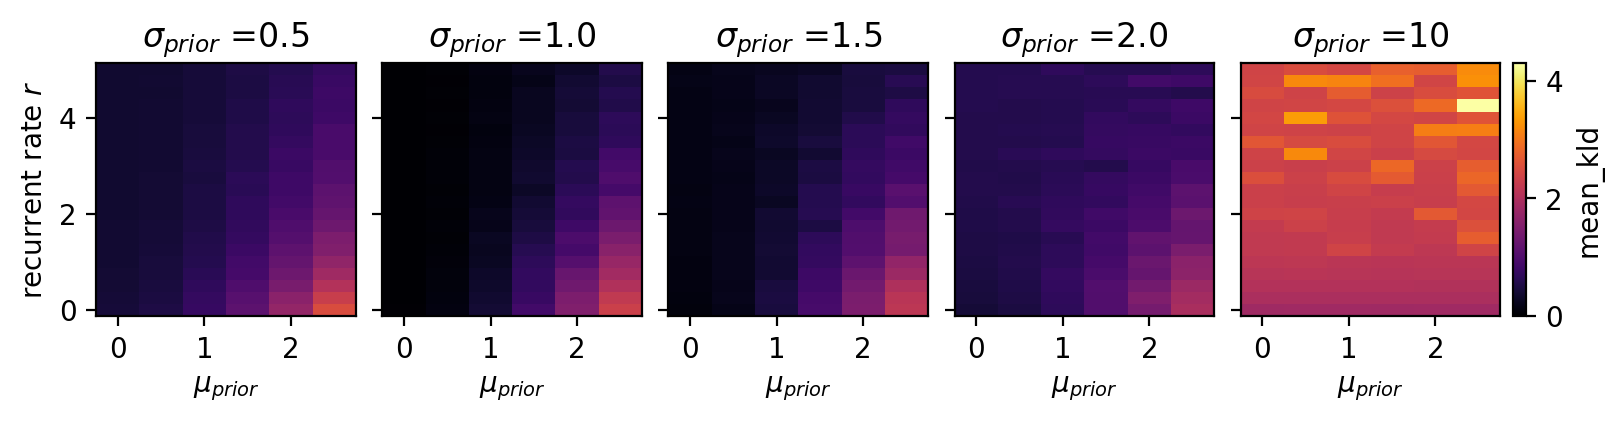

In [7]:
# Plot a heatmap of the mean KLD values of ds_kld with axis mu and rate, with sd=1.0

kld_min = 0
kld_max = float(ds.mean_kld.max())

fig, ax = plt.subplots(
    1, 5, constrained_layout=True, figsize=(8, 2), sharex=True, sharey=True
)
for i, sd in enumerate(sd_range):
    if ax[i] != ax[-1] and ax[i] != ax[0]:
        ds.sel(sd=sd).mean_kld.plot(
            ax=ax[i],
            x="mu",
            y="rate",
            vmin=kld_min,
            vmax=kld_max,
            cmap=cmap,
            add_colorbar=False,
        )
        ax[i].set_xlabel("$\mu_{prior}$")
        ax[i].set_ylabel("")
        ax[i].set_title(str("$\sigma_{prior}$ =" + str(sd)))
    elif ax[i] == ax[0]:
        ds.sel(sd=sd).mean_kld.plot(
            ax=ax[i],
            x="mu",
            y="rate",
            vmin=kld_min,
            vmax=kld_max,
            cmap=cmap,
            add_colorbar=False,
        )
        ax[i].set_xlabel("$\mu_{prior}$")
        ax[i].set_ylabel("recurrent rate $r$")
        ax[i].set_title(str("$\sigma_{prior}$ =" + str(sd)))
    else:
        ds.sel(sd=sd).mean_kld.plot(
            ax=ax[i],
            x="mu",
            y="rate",
            vmin=kld_min,
            vmax=kld_max,
            cmap=cmap,
            add_colorbar=True,
        )
        ax[i].set_xlabel("$\mu_{prior}$")
        ax[i].set_ylabel("")
        ax[i].set_title(str("$\sigma_{prior}$ =" + str(sd)))

fig.savefig("graphics-output/TMP-kld_heatmap.png", dpi=3000, transparent=True)